In [1]:
# external packages
import os
import sys
from argparse import Namespace
from pathlib import Path

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import yaml
from matplotlib.patches import Rectangle
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# own code
sys.path.append('../')
from datasets import process_images_3d
from preprocessing import get_array_from_nifti, roi_crop_multiple_images

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

torch==1.10.2+cpu
numpy==1.22.3
torchvision==0.11.3+cpu
matplotlib==3.5.1
pytorch_lightning==1.5.10
yaml==6.0
SimpleITK==2.0.2


This notebook is to make plots of MRIs and predicted segmentations which have already saved using ```inference_{fibrosis/myocard}_segmentation.py```

In [6]:
def glob_exactly_one_file(directory, identifier_string):
    file = [f for f in directory.glob(f"{identifier_string}")]
    assert len(file) != 0, f"Found no file in {directory} matching {identifier_string}"
    assert len(file) == 1, f"Found multiple files: {file}"
    return file[0]

def get_segmentation_arrays(img_dir, pid, gt_fib_dir=None, gt_myo_dir=None, pred_myo_dir=None, pred_fib_dirs=None, pred_fib_thresholds=None, dataset="deeprisk", pred_myo_threshold=0.4):
    """ Retrieve all necessary images for a patient"""
    assert dataset in ['deeprisk', 'emidec']
    
    if dataset == 'deeprisk':
        gt_fib_file = glob_exactly_one_file(gt_fib_dir, f"*{pid}*")
        gt_fib_array = get_array_from_nifti(gt_fib_file)
        
        sequence_identifier = gt_fib_file.stem[:22]
        gt_myo_file = glob_exactly_one_file(gt_myo_dir, f"*{sequence_identifier}*")
        gt_myo_array = get_array_from_nifti(gt_myo_file)
        
        img_file = glob_exactly_one_file(img_dir, f"*{sequence_identifier}*")
        img_array  = get_array_from_nifti(img_file)
    elif dataset == "emidec":
        sequence_identifier = pid
        gt_file = glob_exactly_one_file(img_dir, f"*/Contours/*{pid}*")
        gt_array = get_array_from_nifti(gt_file)
        # legend ground truth: (background (0), cavity(1), normal myocardium (2), myocardial infarction (3) and no-reflow (4)), all_myocardium = union(2, 3, 4)
        gt_no_reflow = gt_array == 4
        gt_fib_array = gt_array == 3
        gt_myo_array = (gt_array == 2) + gt_fib_array + gt_no_reflow
        
        img_file = glob_exactly_one_file(img_dir, f"*/Images/*{pid}*")
        img_array  = get_array_from_nifti(img_file)
        
    pred_fib_files = [glob_exactly_one_file(pred_fib_dir, f"*{sequence_identifier}*") for pred_fib_dir in pred_fib_dirs]
    if pred_fib_thresholds is not None:
        pred_fib_arrays = [get_array_from_nifti(file) > t for file, t in zip(pred_fib_files, pred_fib_thresholds)]
    else:
        # for showing probability maps
        pred_fib_arrays = [get_array_from_nifti(file) for file in pred_fib_files]
    pred_myo_file = glob_exactly_one_file(pred_myo_dir, f"*{sequence_identifier}*")
    pred_myo_array = get_array_from_nifti(pred_myo_file) > pred_myo_threshold
    
    arrays = []
    array_names = []
    
    arrays.append(img_array)
    array_names.append('img')
    
    arrays.append(gt_fib_array)
    array_names.append('gt_fib')
    
    arrays.append(gt_myo_array)
    array_names.append('gt_myo')
    
    for i, pred_fib_array in enumerate(pred_fib_arrays):
        arrays.append(pred_fib_array)
        array_names.append(f'pred_fib_{i}')
    
    arrays.append(pred_myo_array)
    array_names.append('pred_myo')
    
    data = process_images_3d(arrays, array_names, transform=None, roi_crop="fixed")
    
    if dataset == 'emidec':
        # emidec mris are stored in reverse order, change to make equal to deeprisk
        for k, v in data.items():
            if torch.is_tensor(v):
                data[k] = torch.flip(v, [1])
    
    def _dice(gt, pred, dim='3D'):
        assert dim in ['2D', '3D']
        gt = gt.numpy()
        pred = pred.numpy()
        if dim == '3D':
            axis = None
        elif dim == '2D':
            axis = (-1, -2, -4)  
        dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))
        return dice
    
    data['Dice_3D_myo'] = _dice(data['gt_myo'], data['pred_myo'], dim='3D')
    data['Dices_3D_fib'] = []
    data['Dices_2D_fib'] = []
    
    for k in data:
        if not 'pred_fib' in k:
            continue
        else:
            pred_fib = data[k]
            data['Dices_3D_fib'].append(_dice(data['gt_fib'], pred_fib, dim='3D'))
            data['Dices_2D_fib'].append(_dice(data['gt_fib'], pred_fib, dim='2D'))
    return data


def plot_segmentation_arrays_single_patient(img_dir, pid,
                             gt_fib_dir=None, gt_myo_dir=None,
                             pred_myo_dir=None, pred_fib_dirs=None,
                             pred_fib_thresholds=None, dataset="deeprisk", pred_myo_threshold=0.4,
                             pred_fib_names=[], gt_threshold = 0.0,
                             subplot_size=3, annotate_dice=True,
                             myo_used=None):
    
    data = get_segmentation_arrays(img_dir, pid,
                                   gt_fib_dir=gt_fib_dir, gt_myo_dir=gt_myo_dir, pred_myo_dir=pred_myo_dir, pred_fib_dirs=pred_fib_dirs,
                                   pred_fib_thresholds=pred_fib_thresholds, dataset=dataset, pred_myo_threshold=pred_myo_threshold)
    
    # make figure
    if myo_used is None:
        myo_used = [False if 'no_myo' in str(pred_fib_dir) else True for pred_fib_dir in pred_fib_dirs]
    
    # load batch
    image = data["img"][0].numpy()
    pred_myo = data["pred_myo"][0].numpy()
    gt_myo = data["gt_myo"][0].numpy()
    gt_fib = data["gt_fib"][0].numpy()
    
    dice_3d_myo = data['Dice_3D_myo']
    print(f"{dice_3d_myo=}")
    dices_3d_fib = data['Dices_3D_fib']
    dices_2d_fib = data['Dices_2D_fib']
    
    slice_idxs = [i for i in range(len(gt_myo))]
    pred_fibs = [[data[k][0][i].numpy() for k in data if 'pred_fib' in k] for i in slice_idxs]
       
    # create fig & axis labels
    n_rows = len(slice_idxs) 
    n_cols = 2+len(pred_fibs[0]) # normal image, ground truth and predictions
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(subplot_size*n_cols,subplot_size*n_rows))
    
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.ylabel("Patient slices")
    
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(n_rows):
        axs[i, 0].set_ylabel(f"{i}")
    axs[0, 0].set_title('Image slice')
    axs[0, 1].set_title('Ground truth')
    for j, name in enumerate(pred_fib_names):
        axs[0, j+2].set_title(f"{name}")
    for ax in axs.flat:
        ax.set_xticks([], [])
        ax.set_yticks([], [])    
        
    for i in range(n_rows):
        axs[i, 0].imshow(image[i], cmap="gray")
        masked_gt_fib = np.ma.masked_where(gt_fib[i] <= gt_threshold, gt_fib[i] > gt_threshold)
        masked_gt_myo = np.ma.masked_where(gt_myo[i] <= gt_threshold, gt_myo[i] > gt_threshold)
        axs[i, 1].imshow(image[i], cmap="gray")
        axs[i, 1].imshow(masked_gt_myo, cmap="GnBu", alpha=0.5, vmin=0.0, vmax=1)
        axs[i, 1].imshow(masked_gt_fib, cmap="bwr", alpha=0.8, vmin=0.0, vmax=1)
        if annotate_dice == True:
            axs[i, 1].text(60, 30, f"Dice 2D\nDice 3D", fontsize='x-large', color='white', weight='bold')
        
        masked_pred_myo = np.ma.masked_where(pred_myo[i] <= pred_myo_threshold, pred_myo[i] > pred_myo_threshold)

        for j, pred_fib in enumerate(pred_fibs[i]):
            axs[i, j+2].imshow(image[i], cmap="gray")
            if myo_used[j] == True:
                axs[i, j+2].imshow(masked_pred_myo, cmap="GnBu", alpha=0.5, vmin=0.0, vmax=1)
            if pred_fib_thresholds is not None:
                masked_pred_fib = np.ma.masked_where(pred_fib < pred_fib_thresholds[j], pred_fib >= pred_fib_thresholds[j])
            else:
                masked_pred_fib = np.ma.masked_where(pred_fib < 0.001, pred_fib >= 0.001)
            axs[i, j+2].imshow(masked_pred_fib, cmap="bwr", alpha=0.8, vmin=0.0, vmax=1)
            if annotate_dice == True:
                axs[i, j+2].text(60, 30, f"{dices_2d_fib[j][i]:.3f}\n{dices_3d_fib[j]:.3f}", fontsize='x-large', color='white', weight='bold')

    plt.show()
    return

def plot_segmentation_arrays_multiple_patients(img_dir, pids, slice_idxs,
                             gt_fib_dir=None, gt_myo_dir=None,
                             pred_myo_dir=None, pred_fib_dirs=None,
                             pred_fib_thresholds=None, dataset="deeprisk", pred_myo_threshold=0.4,
                             pred_fib_names=[], gt_threshold = 0.0,
                             subplot_size=3, annotate_dice='2D', ylabel='Patient',
                                              myo_used=None,
                                              myo_pred_separate_column=False,
                                              label_rows=True):
    assert annotate_dice in [False, '2D', '3D']
    if myo_used is None:
        myo_used = [False if 'no_myo' in str(pred_fib_dir) else True for pred_fib_dir in pred_fib_dirs]
    image = []
    pred_myo = []
    gt_myo = []
    gt_fib = []
    dice_3d_myo = []
    dices_3d_fib = []
    dices_2d_fib = []
    pred_fibs = []
    for pid, slice_idx in zip(pids, slice_idxs):        
        data = get_segmentation_arrays(img_dir, pid,
                                       gt_fib_dir=gt_fib_dir, gt_myo_dir=gt_myo_dir, pred_myo_dir=pred_myo_dir, pred_fib_dirs=pred_fib_dirs,
                                       pred_fib_thresholds=pred_fib_thresholds, dataset=dataset, pred_myo_threshold=pred_myo_threshold)
    
        # load batch
        image.append(data["img"][0].numpy()[slice_idx])
        pred_myo.append(data["pred_myo"][0].numpy()[slice_idx])
        gt_myo.append(data["gt_myo"][0].numpy()[slice_idx])
        gt_fib.append(data["gt_fib"][0].numpy()[slice_idx])

        dice_3d_myo.append(data['Dice_3D_myo'])
        
        dices_3d_fib.append(data['Dices_3D_fib'])
        dices_2d_fib.append([x[slice_idx] for x in data['Dices_2D_fib']])
        pred_fib_keys = [k for k in data if 'pred_fib' in k]
        pred_fibs.append([data[k][0][slice_idx] for k in pred_fib_keys])
    print(f"{dice_3d_myo=}")
    print(f"{dices_2d_fib=}")
    # create fig & axis labels
    n_rows = len(slice_idxs) 
    n_cols = 2+len(pred_fibs[0]) # normal image, ground truth and predictions
    if myo_pred_separate_column == True:
        n_cols += 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(subplot_size*n_cols,subplot_size*n_rows), squeeze=False)
    
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.ylabel(ylabel)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    if label_rows == True:
        for i, letter in zip(range(n_rows-1, -1, -1), map(chr,range(ord('A'),ord('Z')+1))):
            axs[i, 0].set_ylabel(f"{letter}")
    axs[0, 0].set_title('Image slice')
    axs[0, 1].set_title('Ground truth')
    if myo_pred_separate_column == True:
        axs[0, 2].set_title('Myocardium prediction')
    
    
    for j, name in enumerate(pred_fib_names):
        axs[0, j+n_cols-len(pred_fibs[0])].set_title(f"{name}")
    for ax in axs.flat:
        ax.set_xticks([], [])
        ax.set_yticks([], [])    
        
    for i in range(n_rows):
        axs[i, 0].imshow(image[i], cmap="gray")
        masked_gt_fib = np.ma.masked_where(gt_fib[i] <= gt_threshold, gt_fib[i] > gt_threshold)
        masked_gt_myo = np.ma.masked_where(gt_myo[i] <= gt_threshold, gt_myo[i] > gt_threshold)
        axs[i, 1].imshow(image[i], cmap="gray")
        #axs[i, 1].imshow(masked_gt_myo, cmap="GnBu", alpha=0.5, vmin=0.0, vmax=1)
        axs[i, 1].imshow(masked_gt_fib, cmap="bwr", alpha=0.8, vmin=0.0, vmax=1)
        
        if annotate_dice == '3D':
            axs[i, 1].text(60, 30, f"Dice 2D\nDice 3D", fontsize='x-large', color='white', weight='bold')
        elif annotate_dice == '2D':
            axs[i, 1].text(60, 30, f"Dice 2D", fontsize='x-large', color='white', weight='bold')
        
        masked_pred_myo = np.ma.masked_where(pred_myo[i] <= pred_myo_threshold, pred_myo[i] > pred_myo_threshold)
        
        if myo_pred_separate_column == True:
            axs[i, 2].imshow(image[i], cmap="gray")
            axs[i, 2].imshow(masked_pred_myo, cmap="GnBu", alpha=0.8, vmin=0.0, vmax=1)

        for j, pred_fib in enumerate(pred_fibs[i]):
            axs[i, j+n_cols-len(pred_fibs[i])].imshow(image[i], cmap="gray")
            if myo_used[j] == True:
                axs[i, j+n_cols-len(pred_fibs[i])].imshow(masked_pred_myo, cmap="GnBu", alpha=0.5, vmin=0.0, vmax=1)
            if pred_fib_thresholds is not None:
                masked_pred_fib = np.ma.masked_where(pred_fib < 0.001, pred_fib >= 0.001)
                pred_fib_cmap = 'bwr'
            else:
                masked_pred_fib = pred_fib
                pred_fib_cmap = 'coolwarm'
            axs[i, j+n_cols-len(pred_fibs[i])].imshow(masked_pred_fib, cmap=pred_fib_cmap, alpha=0.8, vmin=0.0, vmax=1)
            if annotate_dice == '3D':
                axs[i, j+n_cols-len(pred_fibs[i])].text(60, 30, f"{dices_2d_fib[i][j]:.3f}\n{dices_3d_fib[i][j]:.3f}", fontsize='x-large', color='white', weight='bold')
            elif annotate_dice == '2D':
                axs[i, j+n_cols-len(pred_fibs[i])].text(60, 30, f"{dices_2d_fib[i][j]:.3f}", fontsize='x-large', color='white', weight='bold')
    plt.show()
    return
    

# Deeprisk fibrosis segmentation results

C:\Users\rcklein\AppData\Local\Temp\ipykernel_15828\1860402763.py:80: RuntimeWarning: invalid value encountered in true_divide
  dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))


dice_3d_myo=0.8793367346938775


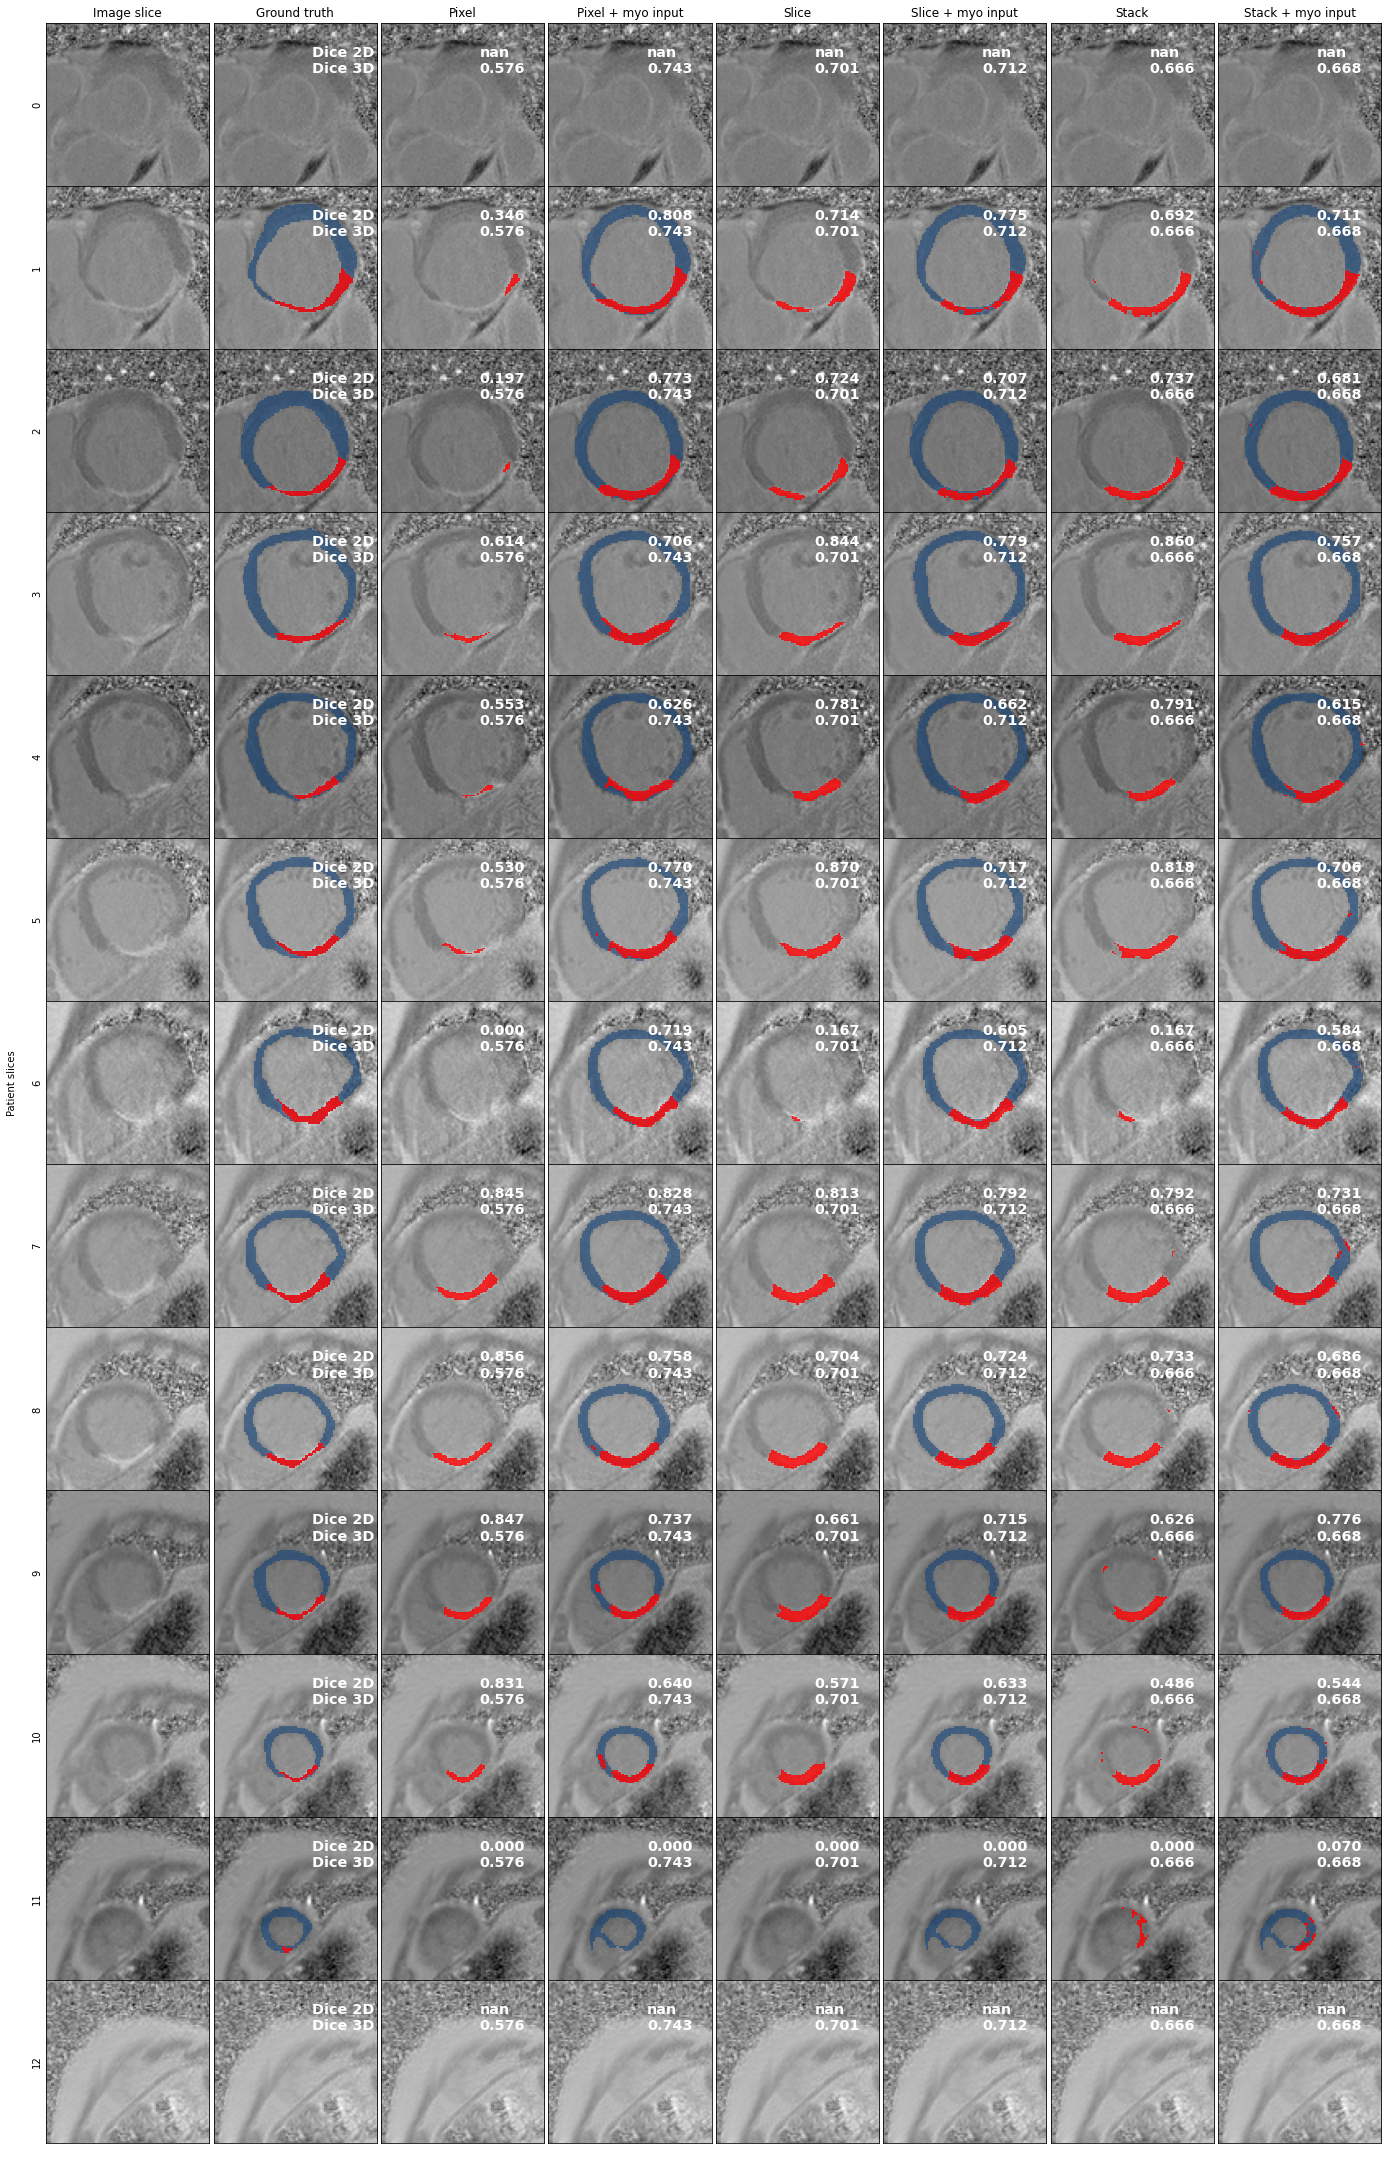

dice_3d_myo=[0.8793367346938775, 0.8793367346938775, 0.8649661334486237]
dices_2d_fib=[[0.5296167247386759, 0.7704280155642024, 0.8695652173913043, 0.717434869739479, 0.8177966101694916, 0.7058823529411765], [0.0, 0.7191780821917808, 0.16718266253869968, 0.6050420168067226, 0.16714697406340057, 0.5841584158415841], [0.0, 0.1320754716981132, 0.4134078212290503, 0.041884816753926704, 0.3769633507853403, 0.23471882640586797]]


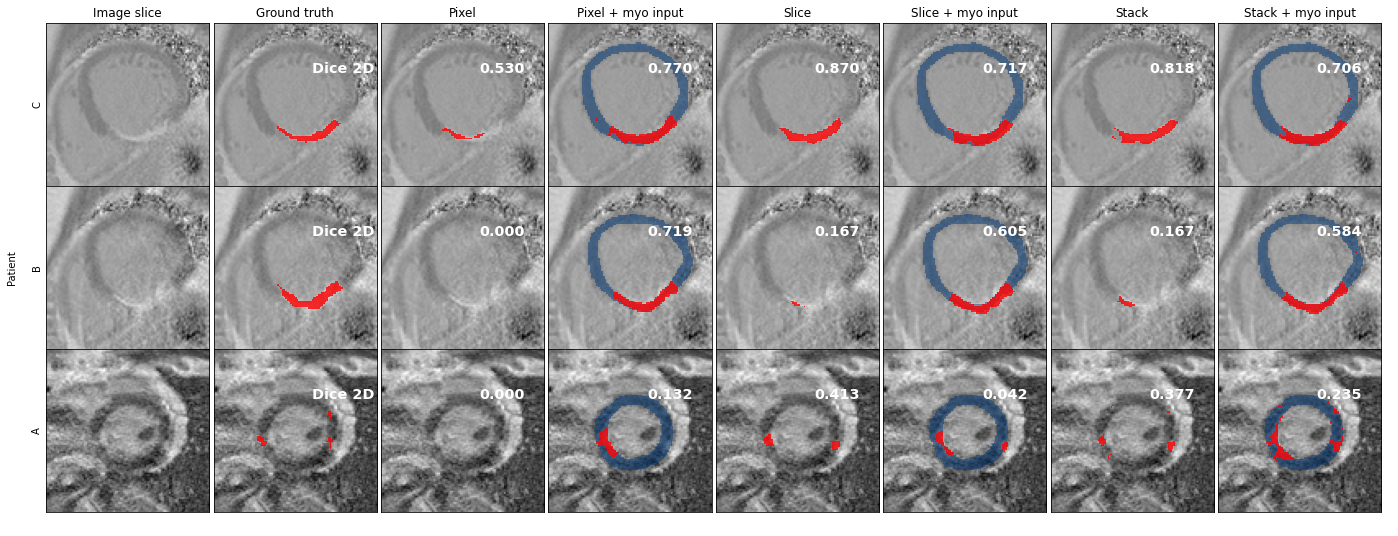

dice_3d_myo=[0.8793367346938775, 0.8649661334486237]
dices_2d_fib=[[0.7704280155642024, 0.8695652173913043, 0.8177966101694916], [0.1320754716981132, 0.4134078212290503, 0.3769633507853403]]


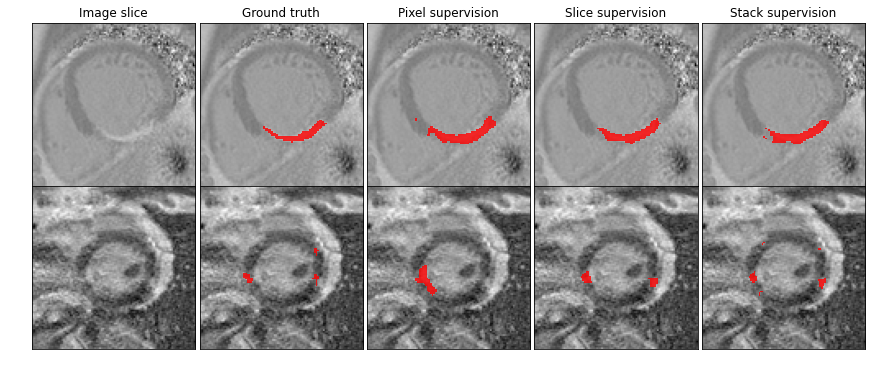

In [7]:

deeprisk_img_dir = Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data\all_niftis_n=657")
deeprisk_gt_fib_dir = Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data\fibrosis_labels_n=117")
deeprisk_gt_myo_dir = Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data\myo_labels_n=117")
deeprisk_pred_myo_dir = Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data\myocard_predictions\deeprisk_myocardium_predictions")

model_dirs = {"Pixel": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_no_myo_input\version_2"),
               "Pixel + myo input": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input\version_2"),
               "Slice": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo\version_0"),
               "Slice + myo input": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_myo\version_0"),
               "Stack": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo\version_0"),
               "Stack + myo input": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_myo\version_0")
                }
model_names = [k for k in model_dirs]
pred_fib_thresholds = [0.9, 0.5, 0.7, 0.9, 0.9, 0.9]


deeprisk_pred_fib_dirs = [f.joinpath("deeprisk_fib_pred") for f in model_dirs.values()]

data = plot_segmentation_arrays_single_patient(deeprisk_img_dir, 'DRAUMC0380',
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=deeprisk_pred_fib_dirs,
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=model_names,
                        subplot_size=3)

paper_pids = ['DRAUMC0380', 'DRAUMC0338', 'DRAUMC1017', 'DRAUMC0270', 'DRAUMC0503']
paper_slice_idxs = [1, 3, 2, 8, 4]

inter_observer_ids = ['DRAUMC0585', 'DRAUMC0634', 'DRAUMC1017']
new_paper_pids = ['DRAUMC0585', 'DRAUMC0634', 'DRAUMC1017', 'DRAUMC0380', 'DRAUMC0503']
new_paper_slice_idxs = [3, 7, 3, 6, 4]

newest_paper_pids = ['DRAUMC0380', 'DRAUMC0380', 'DRAUMC0503']
newest_paper_slice_idxs = [5, 6, 4]



data = plot_segmentation_arrays_multiple_patients(deeprisk_img_dir, newest_paper_pids, newest_paper_slice_idxs,
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=deeprisk_pred_fib_dirs,
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=model_names,
                        subplot_size=3)

######################################### only best pixel-level, slice-level and stack-level model
best_model_dirs = {"Pixel supervision": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\full_myo_input\version_2"),
               "Slice supervision": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\slice_no_myo\version_0"),
               "Stack supervision": Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_segmentation_fib\stack_no_myo\version_0"),
                }
best_model_names =  [k for k in best_model_dirs]
best_pred_fib_thresholds = [0.5, 0.7, 0.9]
best_deeprisk_pred_fib_dirs = [f.joinpath("deeprisk_fib_pred") for f in best_model_dirs.values()]
plot_segmentation_arrays_multiple_patients(deeprisk_img_dir, newest_paper_pids[::2], newest_paper_slice_idxs[::2],
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=best_deeprisk_pred_fib_dirs,
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=best_pred_fib_thresholds,
                        pred_fib_names=best_model_names,
                        subplot_size=3,
                        annotate_dice=False, 
                        ylabel='',
                        myo_used=[False]*3,
                        label_rows=False)

# Emidec fibrosis segmentation results

C:\Users\rcklein\AppData\Local\Temp\ipykernel_15828\1860402763.py:80: RuntimeWarning: invalid value encountered in true_divide
  dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))


dice_3d_myo=0.7146758922068464


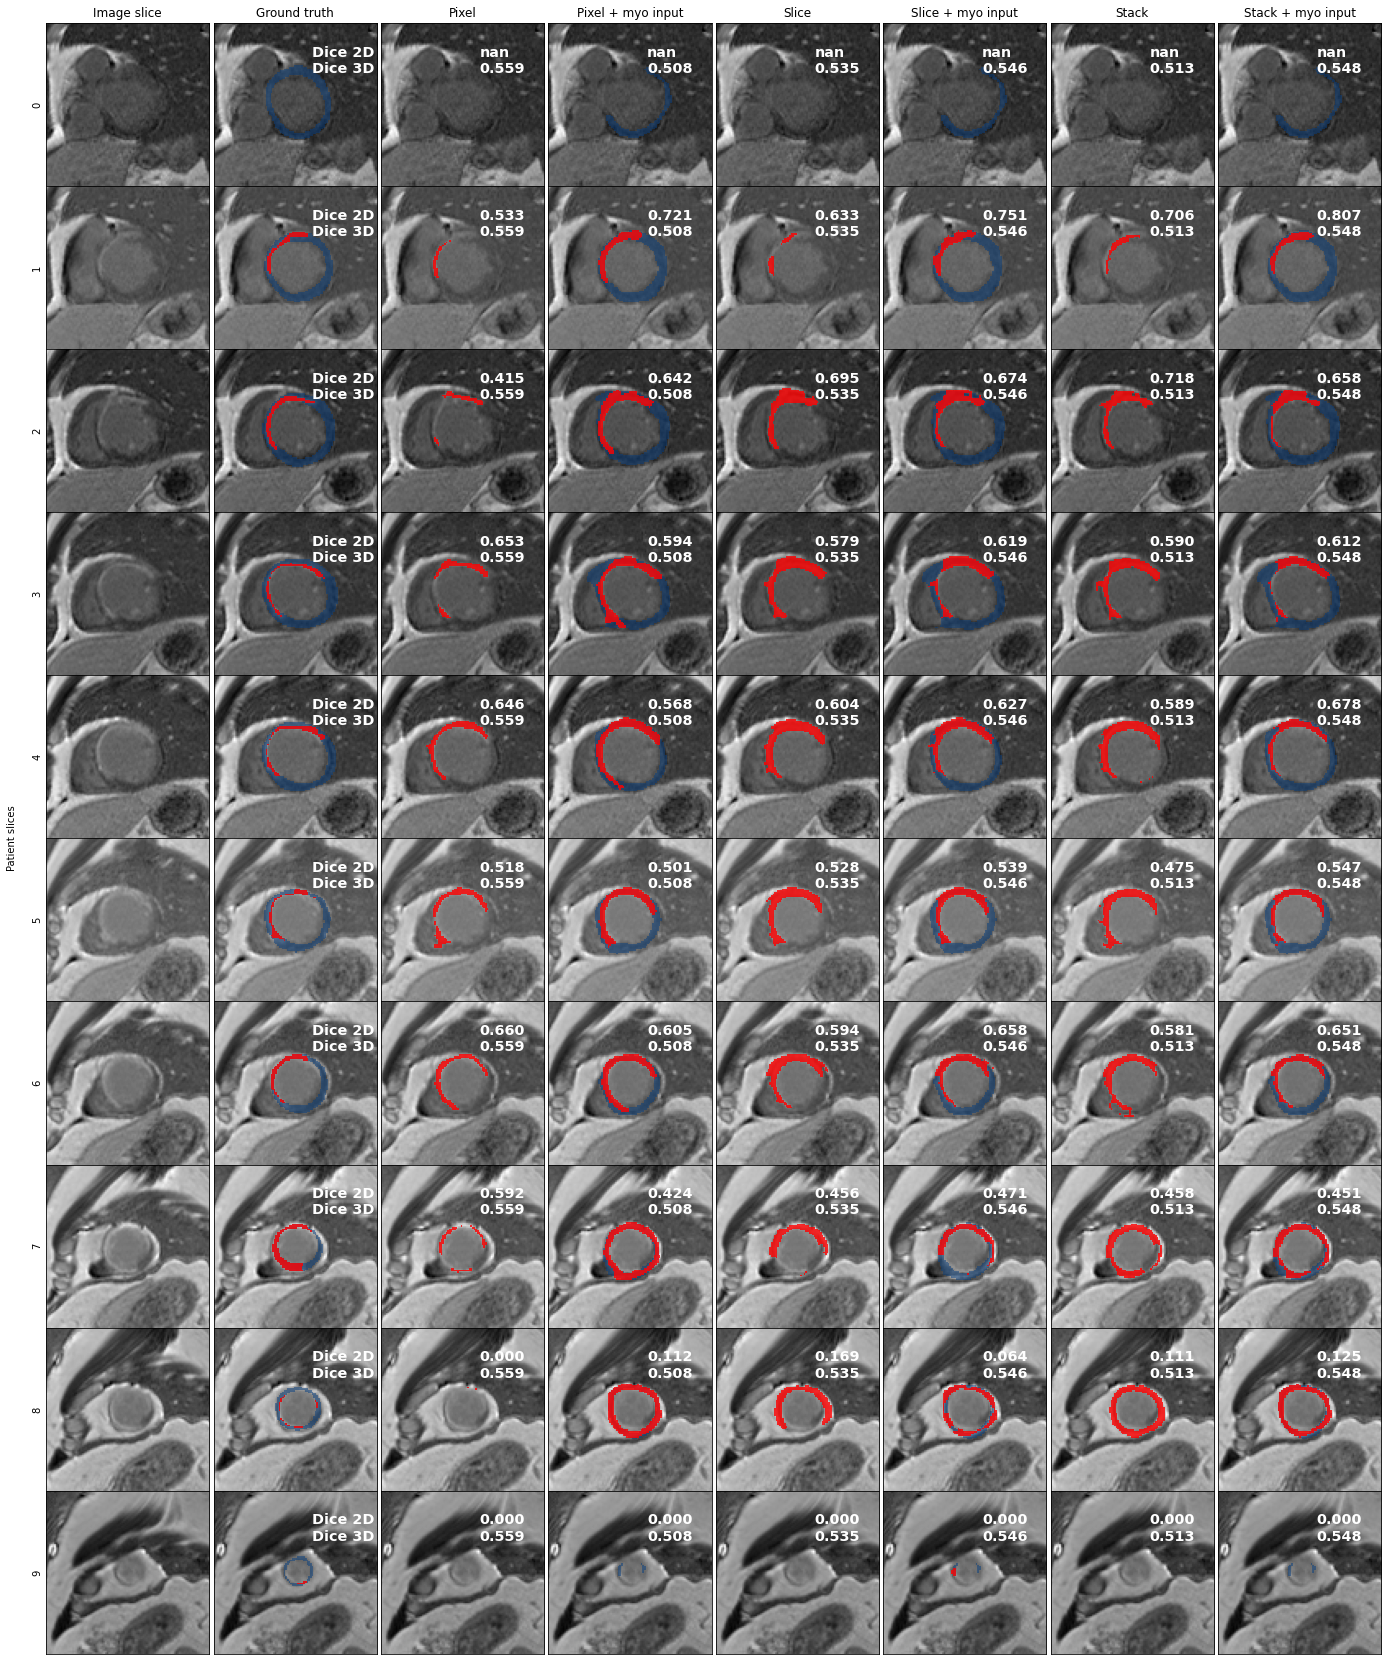

In [8]:
emidec_img_dir = Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data\emidec-dataset-1.0.1")
emidec_pred_myo_dir = Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data\myocard_predictions\emidec_myocardium_predictions")

emidec_pred_fib_dirs = [f.joinpath("emidec_fib_pred") for f in model_dirs.values()]

data = plot_segmentation_arrays_single_patient(emidec_img_dir, 'P047',
                        pred_fib_dirs=emidec_pred_fib_dirs,
                        pred_myo_dir=emidec_pred_myo_dir,
                        dataset='emidec',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=model_names,
                        subplot_size=3)
#####


C:\Users\rcklein\AppData\Local\Temp\ipykernel_15828\1860402763.py:80: RuntimeWarning: invalid value encountered in true_divide
  dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))


dice_3d_myo=[0.865, 0.5689187723674222, 0.7571140077106664]
dices_2d_fib=[[0.48847926267281105, 0.05747126436781609, 0.7555555555555555, 0.7070707070707071, 0.8357348703170029, 0.6106442577030813], [0.6622950819672131, 0.0, 0.5376344086021505, 0.14285714285714285, 0.38345864661654133, 0.0], [0.0, 0.2608695652173913, 0.7, 0.6292134831460674, 0.6786786786786787, 0.32904884318766064]]


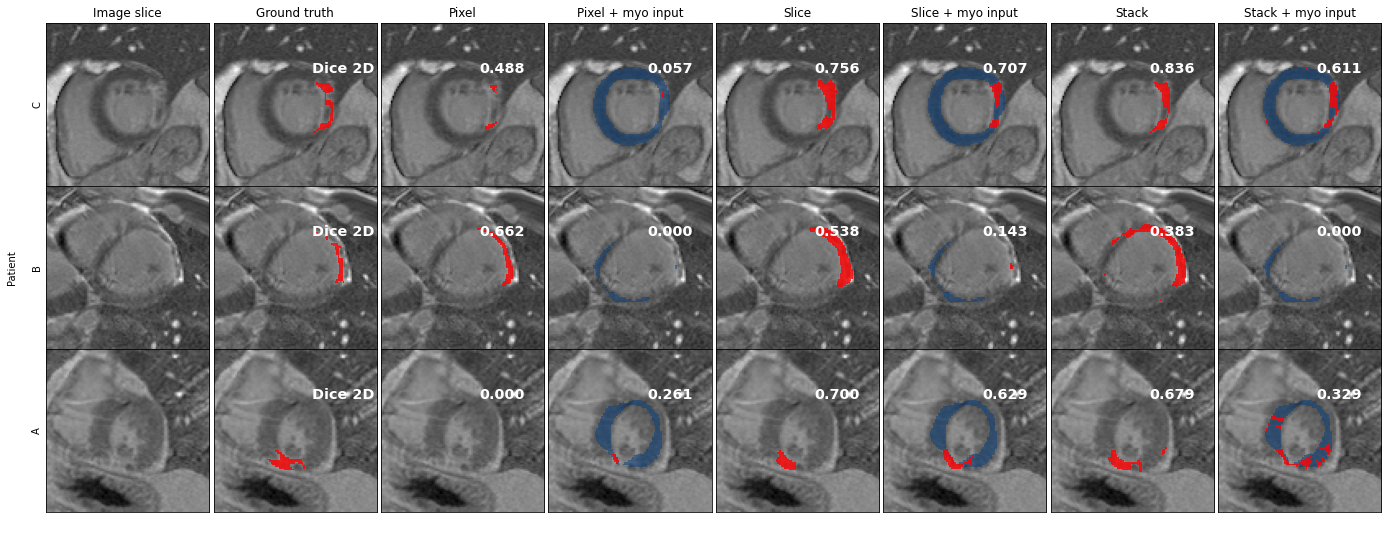

dice_3d_myo=[0.865, 0.7571140077106664]
dices_2d_fib=[[0.05747126436781609, 0.7555555555555555, 0.8357348703170029], [0.2608695652173913, 0.7, 0.6786786786786787]]


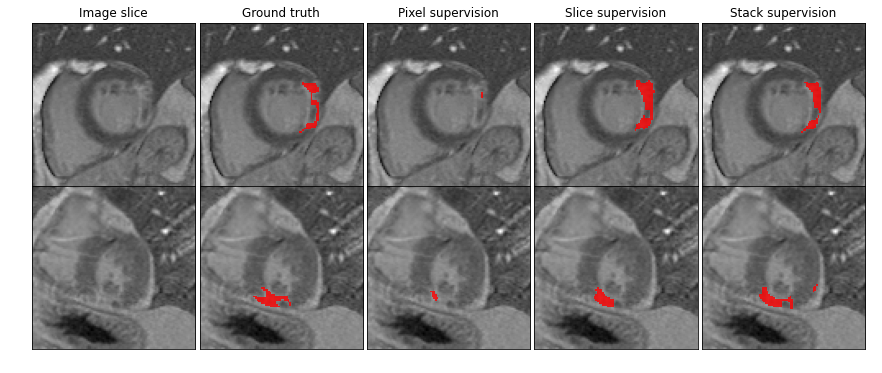

In [10]:
emidec_paper_pids = ['P100', 'P099', 'P098', 'P001', 'P004', 'P010']
emidec_paper_slice_idxs = [1, 3, 5, 2, 5, 2]

emidec_paper_pids = ['P100', 'P099', 'P010']
emidec_paper_slice_idxs = [1, 3, 2]

data = plot_segmentation_arrays_multiple_patients(emidec_img_dir, emidec_paper_pids, emidec_paper_slice_idxs,
                        pred_fib_dirs=emidec_pred_fib_dirs,
                        pred_myo_dir=emidec_pred_myo_dir,
                        dataset='emidec',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=model_names,
                        subplot_size=3)

######################################### only best pixel-level, slice-level and stack-level model

best_emidec_pred_fib_dirs = [f.joinpath("emidec_fib_pred") for f in best_model_dirs.values()]
plot_segmentation_arrays_multiple_patients(emidec_img_dir, emidec_paper_pids[::2], emidec_paper_slice_idxs[::2],
                        pred_fib_dirs=best_emidec_pred_fib_dirs,
                        pred_myo_dir=emidec_pred_myo_dir,
                        dataset='emidec',
                        pred_fib_thresholds=best_pred_fib_thresholds,
                        pred_fib_names=best_model_names,
                        subplot_size=3,
                        annotate_dice=False, 
                        ylabel='',
                        myo_used=[False]*3,
                        label_rows=False)

# Oracle pseudolabels


Visualize the fibrosis pseudolabels which have been created by taking ground truth as prediction.
This shows the maximum attainable results using the given pseudolabel hyperparameters.

C:\Users\rcklein\AppData\Local\Temp\ipykernel_848\4230440775.py:81: RuntimeWarning: invalid value encountered in true_divide
  dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))


dice_3d_myo=0.7224472393945853


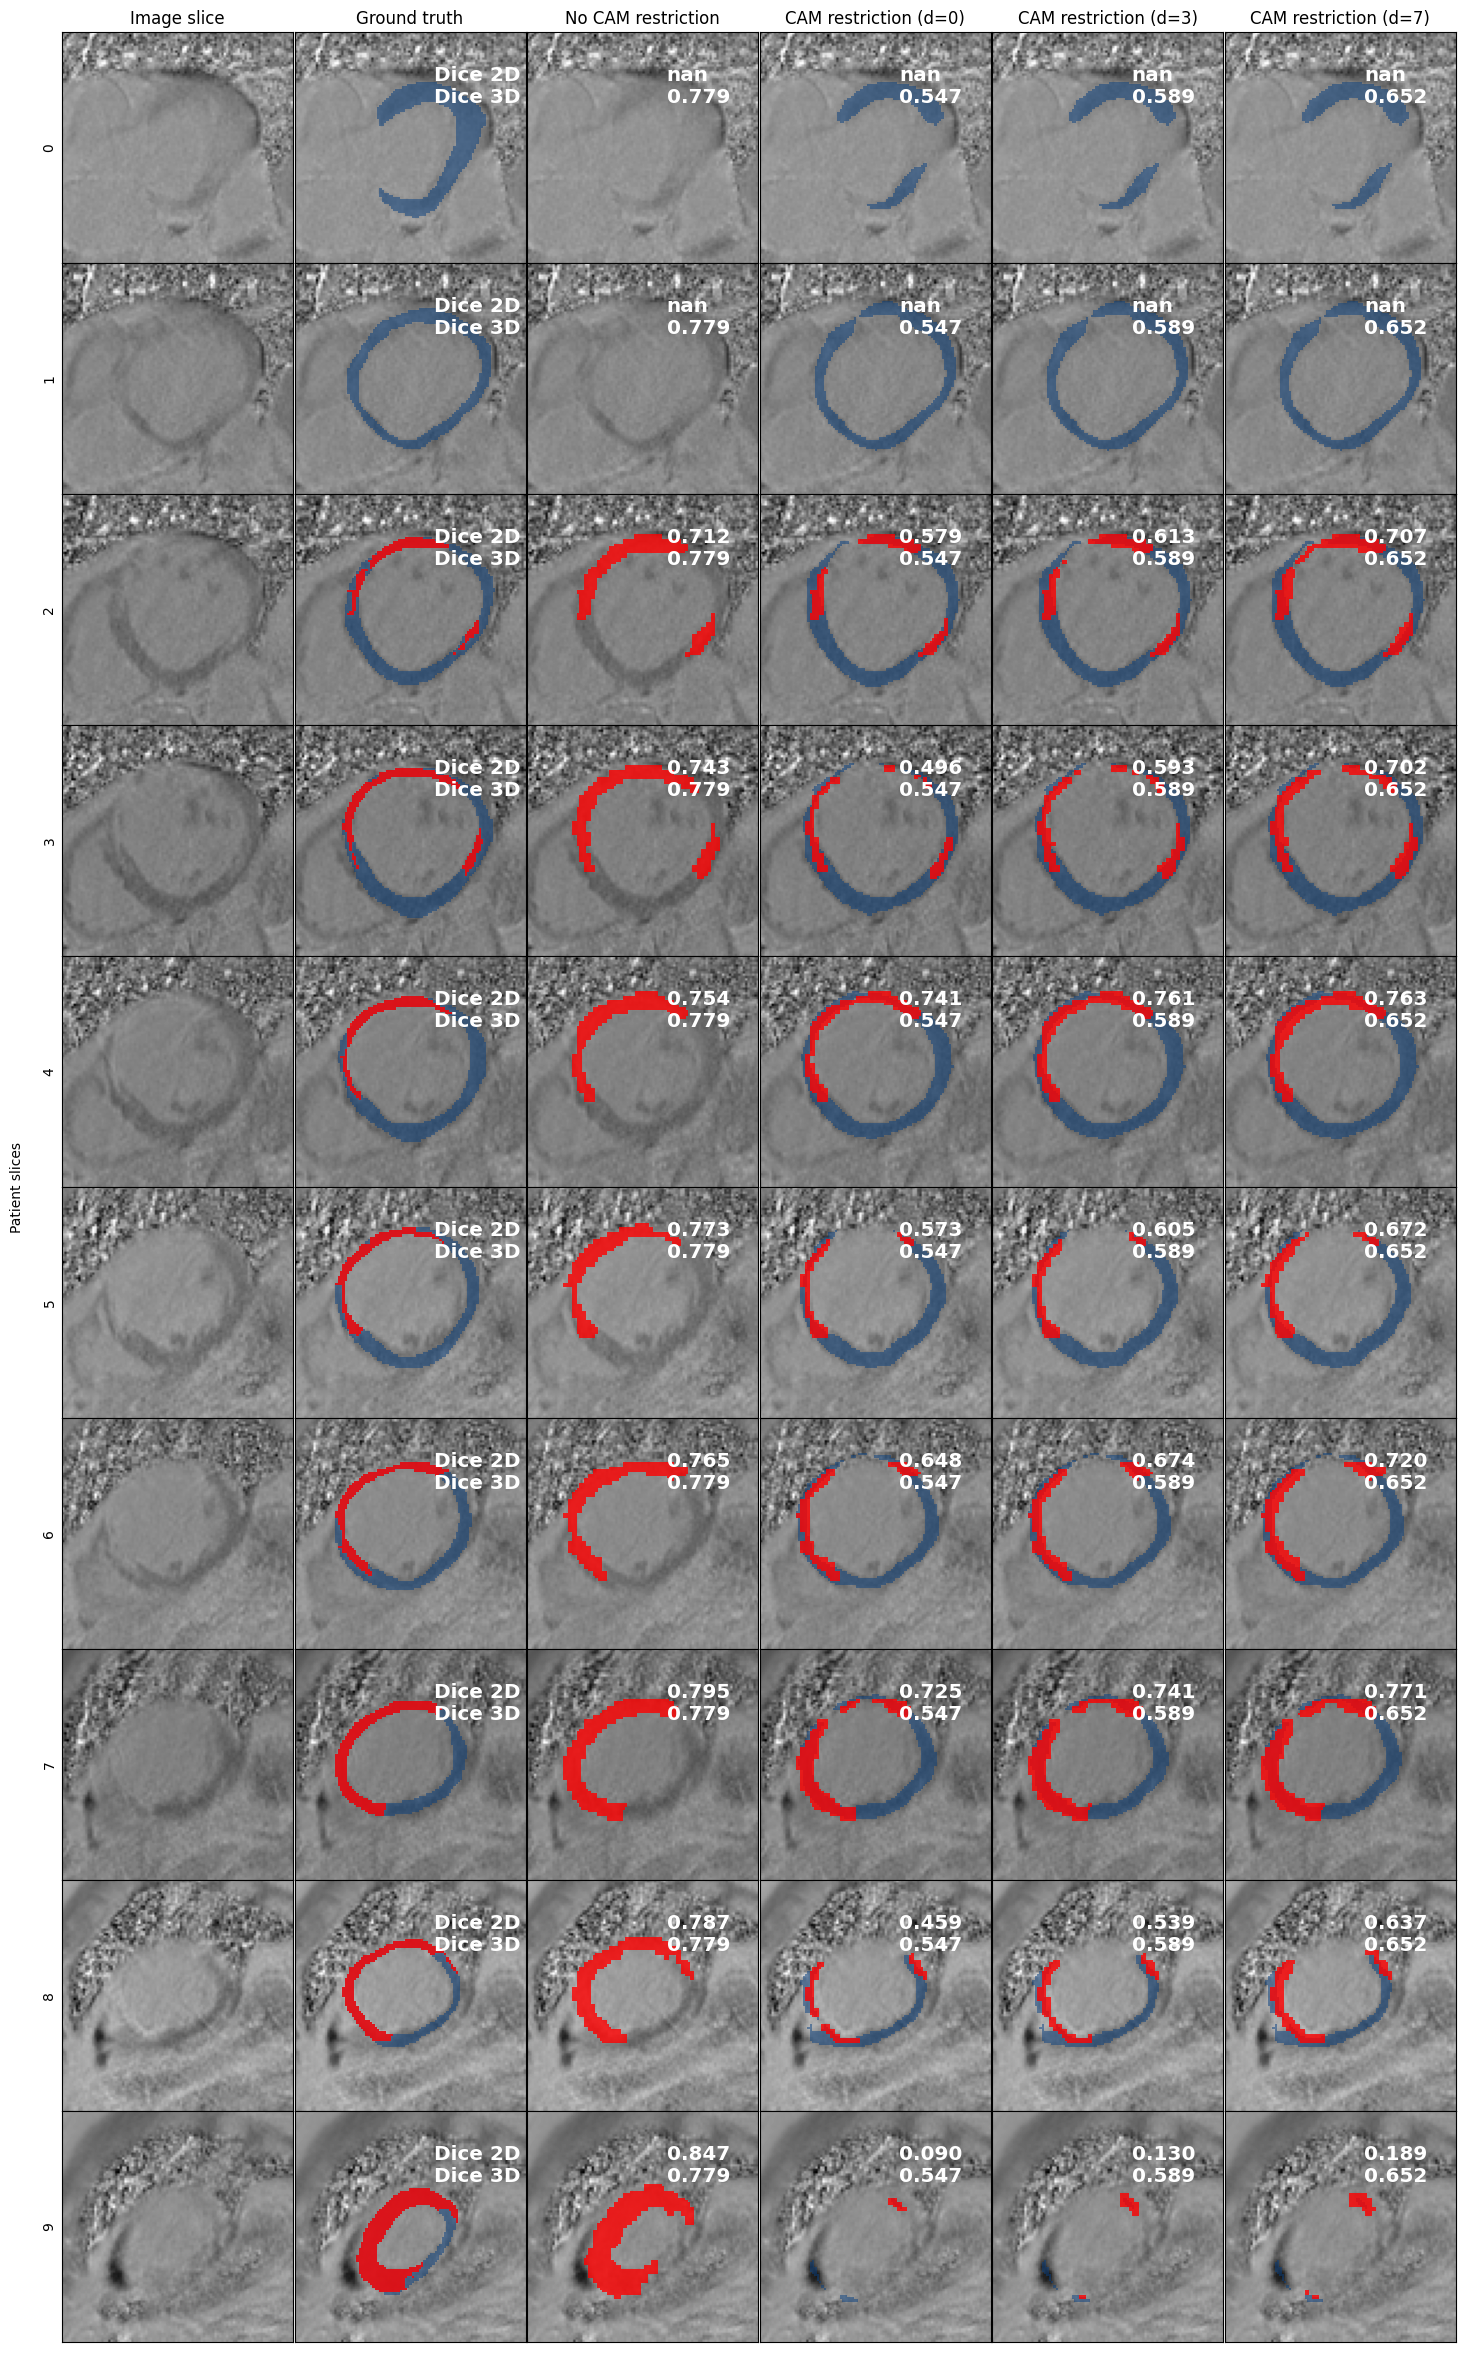

dice_3d_myo=[0.7224472393945853, 0.8295681198355518]


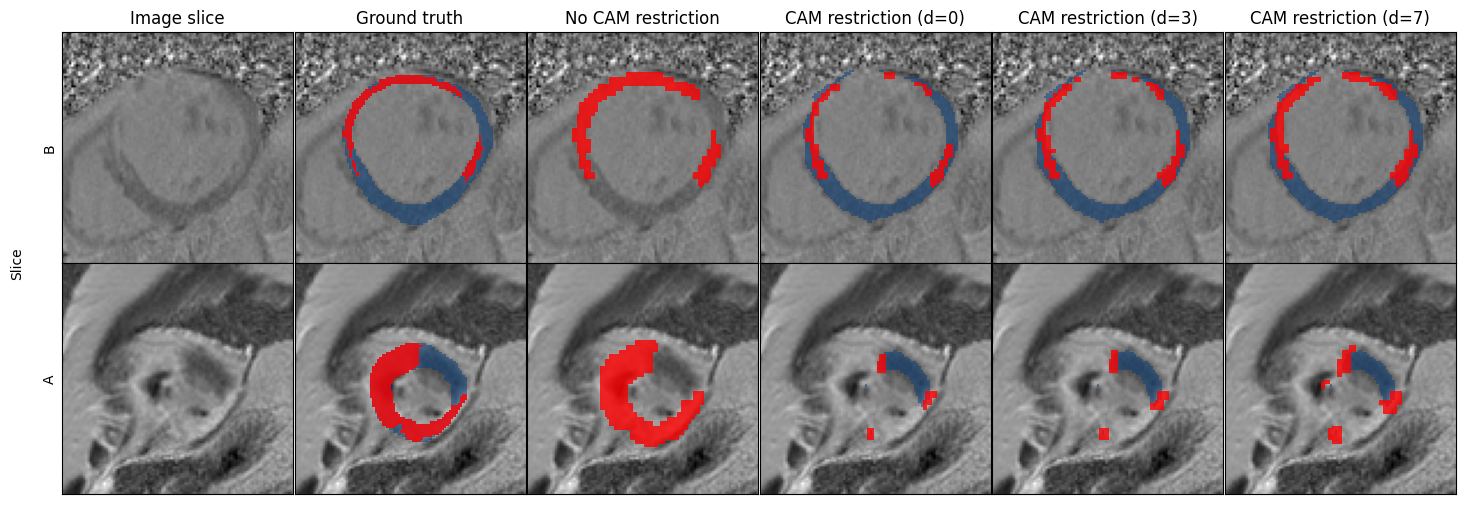

In [162]:
oracle_pred_fib_dirs = [Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_3D\drnd_no_myo_input\version_2\pseudolabels_cheat_no_restriction"),
                       Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_3D\drnd_no_myo_input\version_2\pseudolabels_cheat_d0"),
                       Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_3D\drnd_no_myo_input\version_2\pseudolabels_cheat_d3"),
                       Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_3D\drnd_no_myo_input\version_2\pseudolabels_cheat_d7"),
                       ]
oracle_names = ['No CAM restriction', 'CAM restriction (d=0)', 'CAM restriction (d=3)', 'CAM restriction (d=7)']
oracle_pids = ['DRAUMC0270', 'DRAUMC0805']
oracle_slice_idxs =  [3, 10]
data = plot_segmentation_arrays_single_patient(deeprisk_img_dir, 'DRAUMC0270',
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=oracle_pred_fib_dirs,
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=[0.01]*4,
                        pred_fib_names=oracle_names,
                        subplot_size=3,
                        myo_used=[False, True, True, True])

data = plot_segmentation_arrays_multiple_patients(deeprisk_img_dir, oracle_pids, oracle_slice_idxs,
                                                    gt_fib_dir=deeprisk_gt_fib_dir,
                                                    gt_myo_dir=deeprisk_gt_myo_dir,
                                                    pred_fib_dirs=oracle_pred_fib_dirs,
                                                    pred_myo_dir=deeprisk_pred_myo_dir,
                                                    dataset='deeprisk',
                                                    pred_fib_thresholds=[0.001]*4,
                                                    pred_fib_names=oracle_names,
                                                    subplot_size=3,
                                                    myo_used=[False, True, True, True],
                                                 annotate_dice=False,
                                                 ylabel='Slice')

# Real pseudolabels

Show the results of actual fibrosis pseudolabels, created based on Class Activation Maps.

C:\Users\rcklein\AppData\Local\Temp\ipykernel_6140\3064882449.py:80: RuntimeWarning: invalid value encountered in true_divide
  dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))


dice_3d_myo=0.9227799227799228


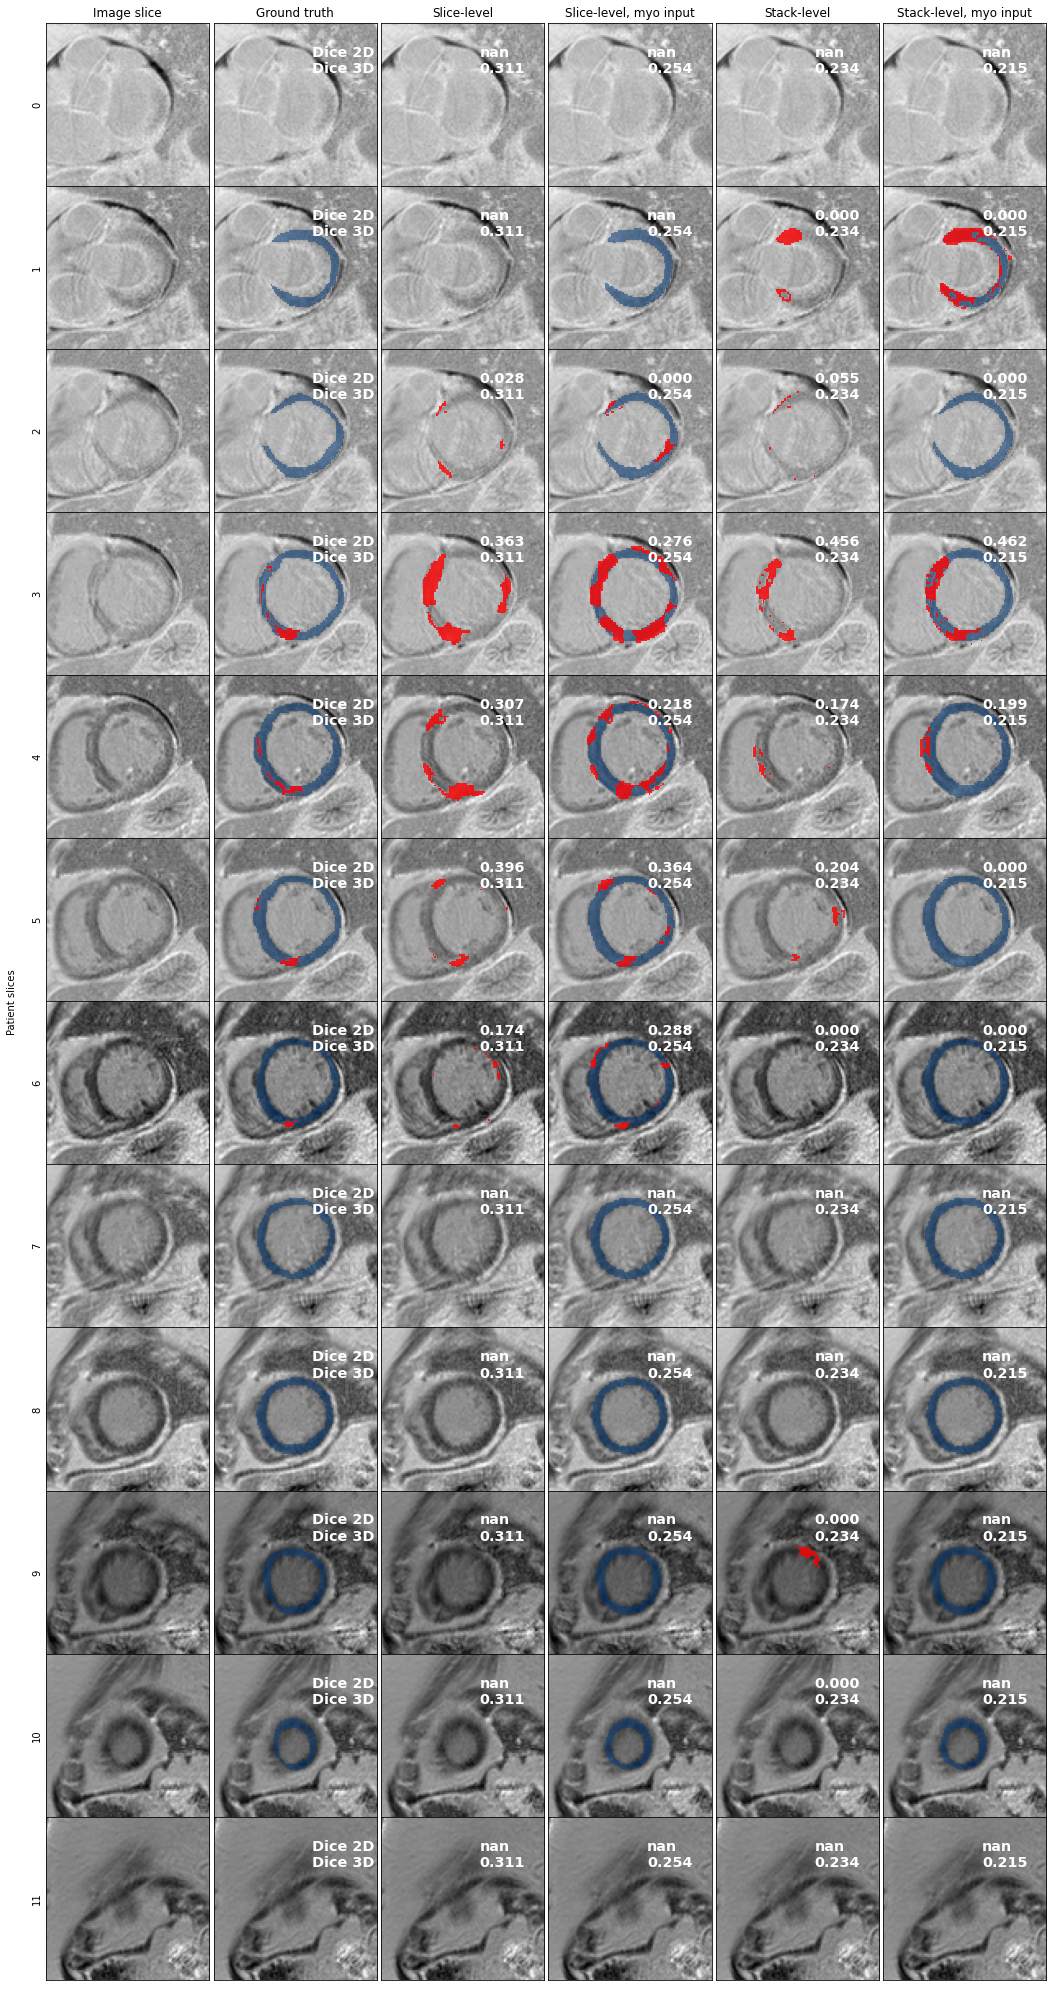

dice_3d_myo=[0.9009569929666782, 0.9036467643904184]
dices_2d_fib=[[0.6480263157894737, 0.7442680776014109], [0.6041958041958042, 0.6971569839307787]]


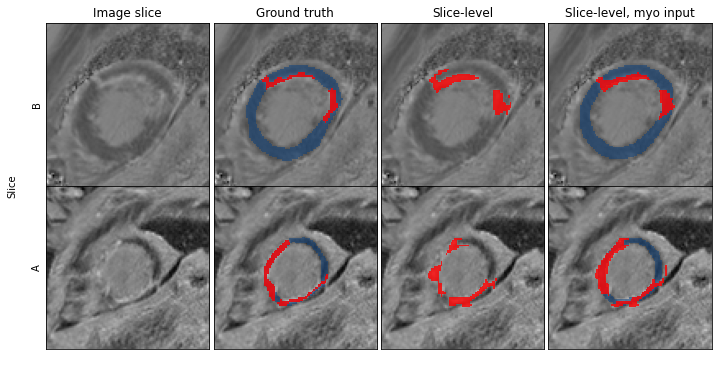

dice_3d_myo=[0.9227799227799228, 0.9009569929666782, 0.9036467643904184]
dices_2d_fib=[[0.0, 0.0], [0.47493403693931396, 0.5757575757575758], [0.5941845764854614, 0.6416243654822334]]


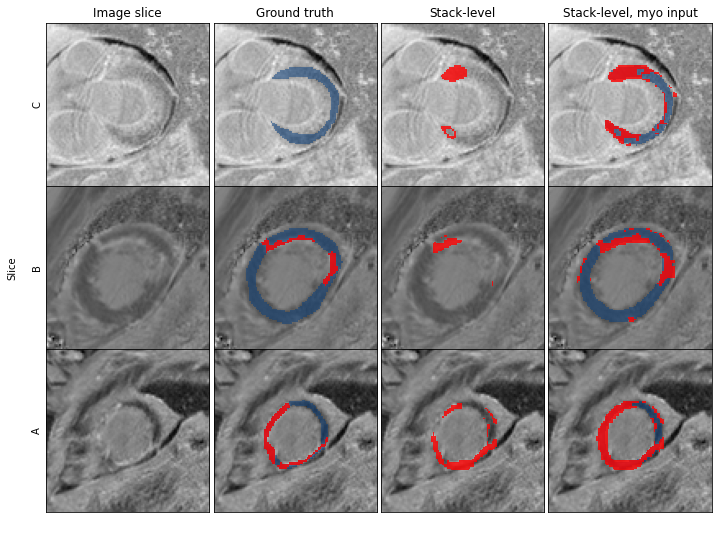

In [56]:
pseudo_pred_fib_dirs = [Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_2D\drnd_no_myo_input\version_3\pseudolabels"),
                       Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_2D\drnd_myo_input\version_3\pseudolabels"),
                       Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_3D\drnd_no_myo_input\version_2\pseudolabels"),
                       Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_3D\drnd_myo_input\version_3\pseudolabels"),
                       ]
pseudo_names = ['Slice-level', 'Slice-level, myo input', 'Stack-level', 'Stack-level, myo input']

pseudo_pids = ['DRAUMC0169', 'DRAUMC0149', 'DRAUMC1164', 'DRAUMC0527', 'DRAUMC0446']
pseudo_slice_idxs = [7, 8, 3, 7, 1]

slice_pseudo_pids = ['DRAUMC0149', 'DRAUMC0527']
slice_pseudo_slice_idxs = [8, 7]
stack_pseudo_pids = ['DRAUMC0446', 'DRAUMC0149', 'DRAUMC0527']
stack_pseudo_slice_idxs = [1, 8, 7]


data = plot_segmentation_arrays_single_patient(deeprisk_img_dir, 'DRAUMC0446',
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=pseudo_pred_fib_dirs,
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=[0.001]*4,
                        pred_fib_names=pseudo_names,
                        subplot_size=3,
                        annotate_dice=True)

data = plot_segmentation_arrays_multiple_patients(deeprisk_img_dir, slice_pseudo_pids, slice_pseudo_slice_idxs,
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=pseudo_pred_fib_dirs[:2],
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=[0.001]*4,
                        pred_fib_names=pseudo_names[:2],
                        subplot_size=3,
                        ylabel='Slice',
                        annotate_dice=False)

data = plot_segmentation_arrays_multiple_patients(deeprisk_img_dir, stack_pseudo_pids, stack_pseudo_slice_idxs,
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=pseudo_pred_fib_dirs[2:],
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=[0.001]*4,
                        pred_fib_names=pseudo_names[2:],
                        subplot_size=3,
                        ylabel='Slice',
                        annotate_dice=False)



C:\Users\rcklein\AppData\Local\Temp\ipykernel_6140\3064882449.py:80: RuntimeWarning: invalid value encountered in true_divide
  dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))


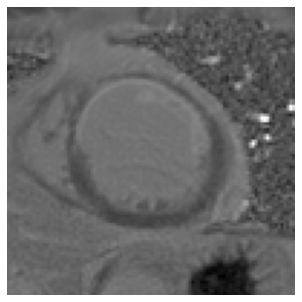

{0.0, 1.0}


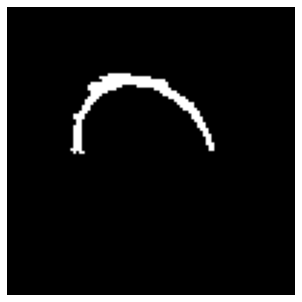

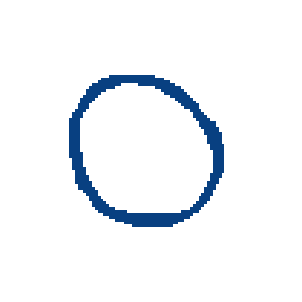

(<Figure size 288x288 with 1 Axes>, <Axes:>)

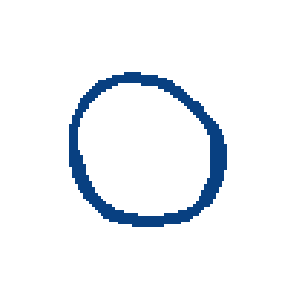

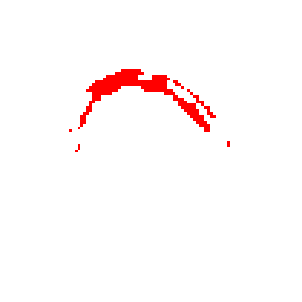

In [74]:
# make plots for model figures
"""data = plot_segmentation_arrays_single_patient(deeprisk_img_dir, 'DRAUMC0002',
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=deeprisk_pred_fib_dirs,
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=model_names,
                        subplot_size=3)"""

data = get_segmentation_arrays(deeprisk_img_dir, 'DRAUMC0002_LGE', #0002 as fibrotic example
                               gt_fib_dir=deeprisk_gt_fib_dir, gt_myo_dir=deeprisk_gt_myo_dir,
                               pred_myo_dir=deeprisk_pred_myo_dir, pred_fib_dirs=pseudo_pred_fib_dirs,
                               pred_fib_thresholds=pred_fib_thresholds, dataset='deeprisk', pred_myo_threshold=0.4)
    
# load batch
slice_idx = 5
image = data["img"][0].numpy()[slice_idx]
pred_myo = data["pred_myo"][0].numpy()[slice_idx]
gt_myo = data["gt_myo"][0].numpy()[slice_idx]
gt_fib = data["gt_fib"][0].numpy()[slice_idx]
pred_fib_keys = [k for k in data if 'pred_fib' in k]
pred_fibs = [data[k][0][slice_idx] for k in pred_fib_keys]

def plot_array(array, size=4, background=0.5, **kwargs):
    fig = plt.figure(frameon=False)
    fig.set_size_inches((size, size))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(array, aspect='equal', **kwargs)
    return fig, ax


plot_array(image, cmap='gray')
plt.show()

print(f"{set([x for x in gt_fib.flatten()])}")
plot_array(gt_fib, cmap='gray')
plt.show()

masked_gt_myo = np.ma.masked_where(gt_myo <= 0.5, gt_myo > 0.5)
plot_array(masked_gt_myo, cmap='GnBu', vmin=0.0, vmax = 1.0)
plt.show()



masked_pred_fib = np.ma.masked_where(pred_fibs[2] <= 0.001, pred_fibs[2] > 0.001)
masked_pred_myo = np.ma.masked_where(pred_myo <= 0.5, pred_myo > 0.5)

plot_array(masked_pred_myo, cmap='GnBu', vmin=0.0, vmax = 1.0)

plot_array(masked_pred_fib, cmap='bwr', vmin=0.0, vmax = 1.0)

# Unrestricted CAM vs restricted CAM

Shows the benefit of restricting the Class Activation Maps to myocardium segmentations.

C:\Users\rcklein\AppData\Local\Temp\ipykernel_848\1742866182.py:81: RuntimeWarning: invalid value encountered in true_divide
  dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))


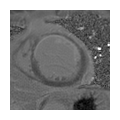

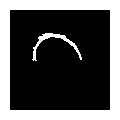

dice_3d_myo=[0.8671934743818506, 0.8671934743818506]


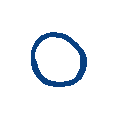

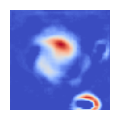

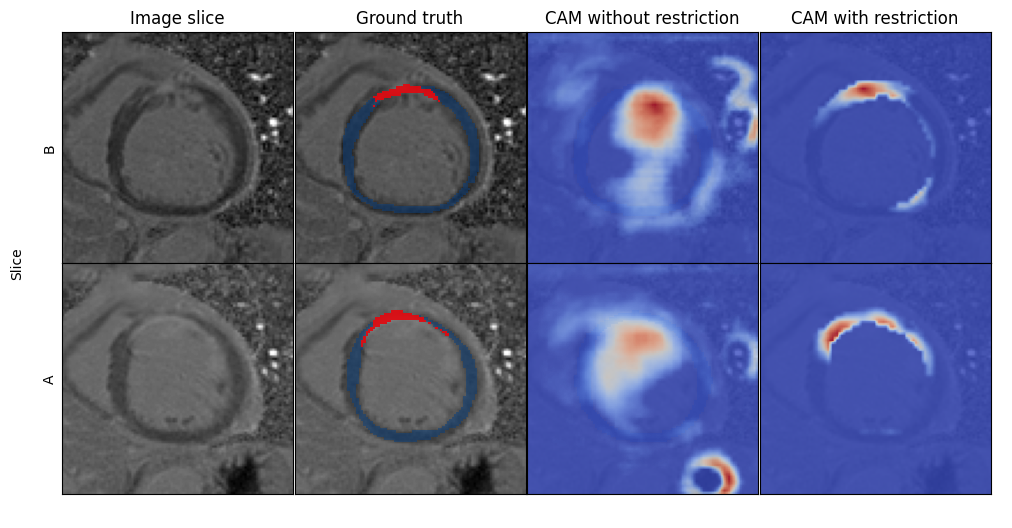

In [117]:
cam_dirs = [Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_2D\drnd_no_restriction\version_0\cams"),
            Path(r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\tb_logs_classification_2D\drnd_no_myo_input\version_3\cams")
           ]
cam_names = ['CAM without restriction', 'CAM with restriction']

data = get_segmentation_arrays(deeprisk_img_dir, 'DRAUMC0002_LGE', #0002 as fibrotic example
                               gt_fib_dir=deeprisk_gt_fib_dir, gt_myo_dir=deeprisk_gt_myo_dir,
                               pred_myo_dir=deeprisk_pred_myo_dir, pred_fib_dirs=cam_dirs,
                               pred_fib_thresholds=None, dataset='deeprisk', pred_myo_threshold=0.4)
    
# load batch
slice_idx = 5
image = data["img"][0].numpy()[slice_idx]
pred_myo = data["pred_myo"][0].numpy()[slice_idx]
gt_myo = data["gt_myo"][0].numpy()[slice_idx]
gt_fib = data["gt_fib"][0].numpy()[slice_idx]
pred_fib_keys = [k for k in data if 'pred_fib' in k]
pred_fibs = [data[k][0][slice_idx] for k in pred_fib_keys]

plot_array(image, cmap='gray')
plt.show()

plot_array(gt_fib, cmap='gray')
plt.show()



masked_pred_fib = np.ma.masked_where(pred_fibs[0] <= 0.001, pred_fibs[0] > 0.001)
masked_pred_myo = np.ma.masked_where(pred_myo <= 0.5, pred_myo > 0.5)

plot_array(masked_pred_myo, cmap='GnBu', vmin=0.0, vmax = 1.0)

plot_array(pred_fibs[0], cmap='coolwarm', vmin=0.0, vmax = 1.0)


data = plot_segmentation_arrays_multiple_patients(deeprisk_img_dir, ['DRAUMC0002_LGE', 'DRAUMC0002_LGE'], [3, 4],
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=cam_dirs,
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=None,
                        pred_fib_names=cam_names,
                        subplot_size=3,
                        annotate_dice=False,
                        ylabel='Slice')

# Myocardium segmentation results

C:\Users\rcklein\AppData\Local\Temp\ipykernel_848\182268664.py:81: RuntimeWarning: invalid value encountered in true_divide
  dice = ((gt> 0) * (pred > 0)).sum(axis=axis) * 2 / (gt.sum(axis=axis) + pred.sum(axis=axis))


dice_3d_myo=0.8219219675117656


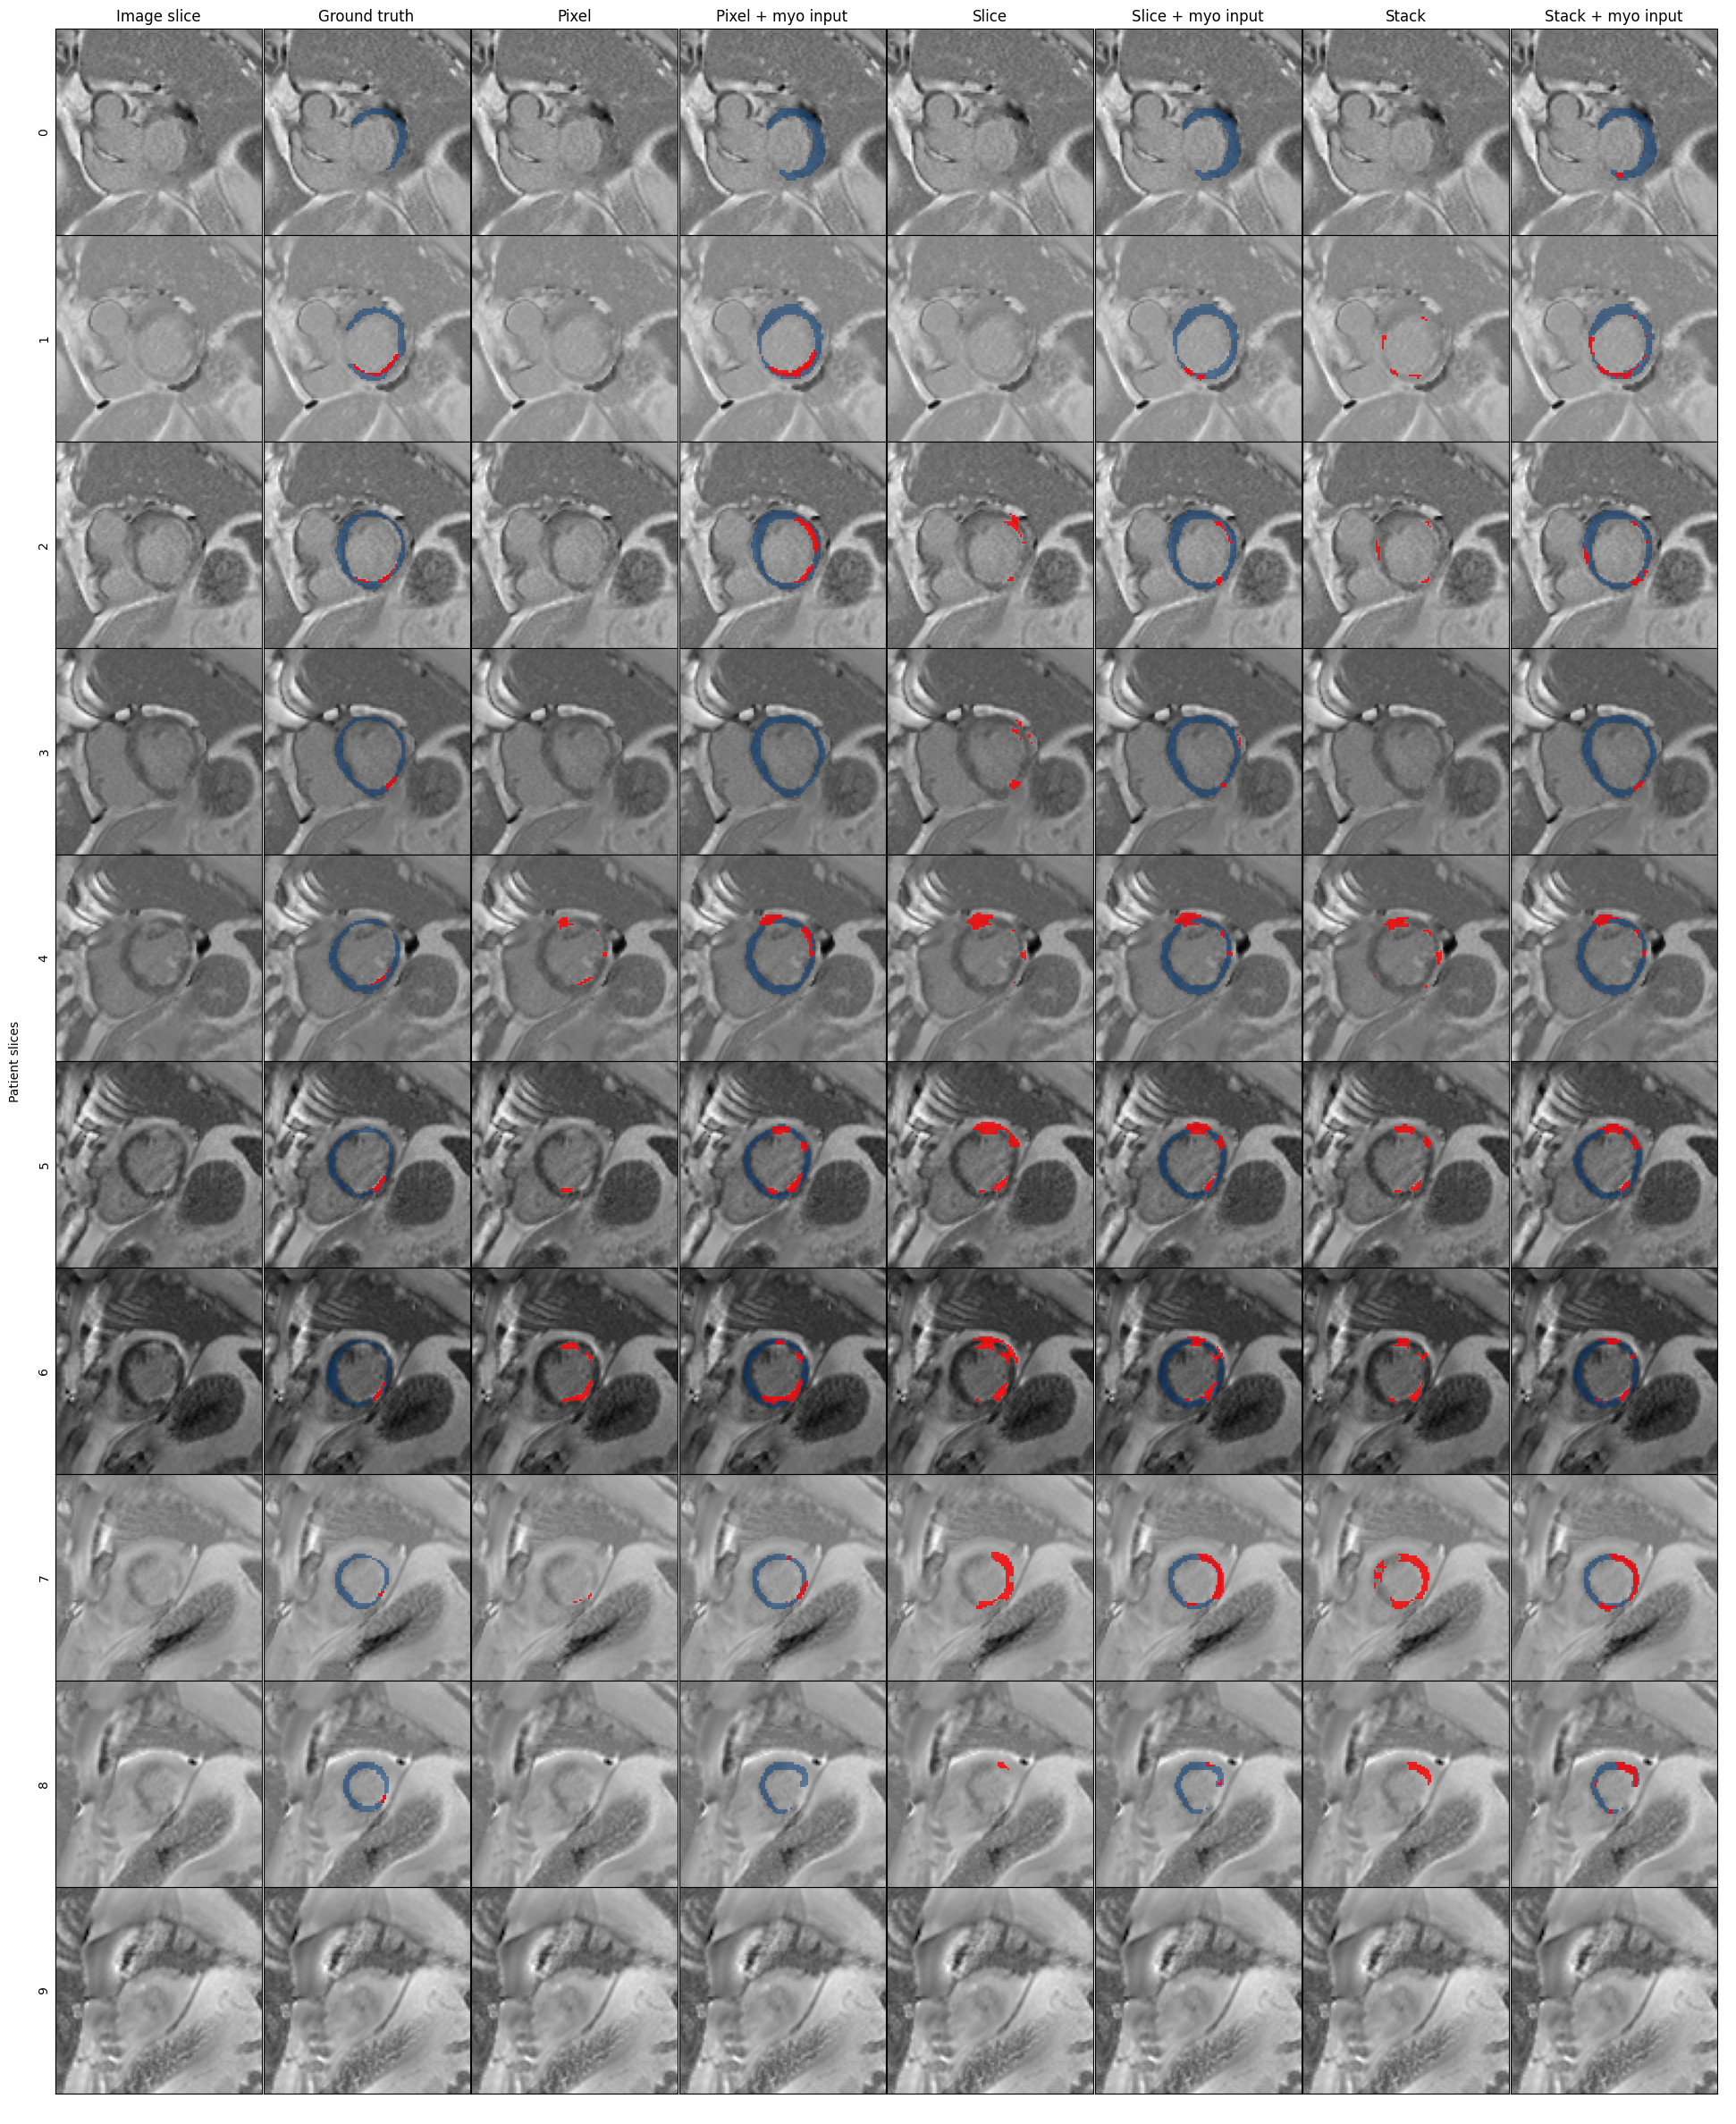

dice_3d_myo=[0.8219219675117656, 0.8219219675117656]
n_cols-len(pred_fibs)=1


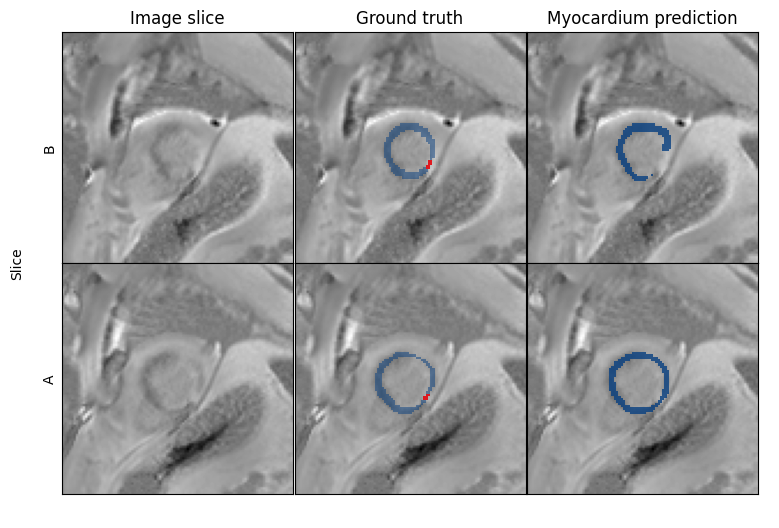

In [250]:
data = plot_segmentation_arrays_single_patient(deeprisk_img_dir, 'DRAUMC0435',
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=deeprisk_pred_fib_dirs,
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=model_names,
                        subplot_size=3,
                        annotate_dice=False)
deeprisk_myo_paper_pids = ['DRAUMC0435', 'DRAUMC0435']
deeprisk_myo_paper_slice_idxs = [8, 7]

data = plot_segmentation_arrays_multiple_patients(deeprisk_img_dir, deeprisk_myo_paper_pids, deeprisk_myo_paper_slice_idxs,
                        gt_fib_dir=deeprisk_gt_fib_dir,
                        gt_myo_dir=deeprisk_gt_myo_dir,
                        pred_fib_dirs=[],
                        pred_myo_dir=deeprisk_pred_myo_dir,
                        dataset='deeprisk',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=[],
                        subplot_size=3,
                        myo_pred_separate_column=True,
                        ylabel='Slice',
                        annotate_dice=False)

In [ ]:

data = plot_segmentation_arrays_single_patient(emidec_img_dir, 'Case_P061',
                        pred_fib_dirs=emidec_pred_fib_dirs,
                        pred_myo_dir=emidec_pred_myo_dir,
                        dataset='emidec',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=model_names,
                        subplot_size=3)

emidec_myo_paper_pids = ['Case_P061', 'Case_P097']
emidec_myo_paper_slice_idxs = [2, 1]

data = plot_segmentation_arrays_multiple_patients(emidec_img_dir, emidec_myo_paper_pids, emidec_myo_paper_slice_idxs,
                        pred_fib_dirs=[],
                        pred_myo_dir=emidec_pred_myo_dir,
                        dataset='emidec',
                        pred_fib_thresholds=pred_fib_thresholds,
                        pred_fib_names=[],
                        subplot_size=3,
                        myo_pred_separate_column=True,
                        annotate_dice=False,
                        ylabel='Slice')